In [ ]:
import numpy as np
import cv2
from PIL import Image
import sys
import os
from tqdm import tqdm

def extract_frames(filename, num_frames, image_size=(380,380)):
	cap_org = cv2.VideoCapture(filename)
	
	if not cap_org.isOpened():
		print(f'Cannot open: {filename}')
		# Return empty lists instead of None
		return [], []
	
	croppedfaces=[]
	idx_list=[]
	frame_count_org = int(cap_org.get(cv2.CAP_PROP_FRAME_COUNT))
	
	if frame_count_org == 0:
		print(f'No frames in video: {filename}')
		cap_org.release()
		return [], []
	
	frame_idxs = np.linspace(0, frame_count_org - 1, num_frames, endpoint=True, dtype=int)
	for cnt_frame in range(frame_count_org): 
		ret_org, frame_org = cap_org.read()
		
		if not ret_org:
			tqdm.write('Frame read {} Error! : {}'.format(cnt_frame,os.path.basename(filename)))
			break
		
		# Check if frame_org is None or empty
		if frame_org is None:
			continue
			
		if cnt_frame not in frame_idxs:
			continue

		# Since video is pre-cropped to face, treat the entire frame as the face
		# Convert BGR to RGB if necessary (depending on video format)
		frame = cv2.cvtColor(frame_org, cv2.COLOR_BGR2RGB)
		
		# Resize to image_size
		resized_frame = cv2.resize(frame, image_size)
		
		# Transpose to (C, H, W)
		croppedfaces.append(resized_frame.transpose((2, 0, 1)))
		idx_list.append(cnt_frame)
	
	cap_org.release()
	# Always return lists (even if empty)
	return croppedfaces, idx_list

def extract_face(frame,model,image_size=(380,380)):
	
	
	faces = model.predict_jsons(frame)

	if len(faces)==0:
		print('No face is detected' )
		return []

	croppedfaces=[]
	for face_idx in range(len(faces)):
		x0,y0,x1,y1=faces[face_idx]['bbox']
		bbox=np.array([[x0,y0],[x1,y1]])
		croppedfaces.append(cv2.resize(crop_face(frame,None,bbox,False,crop_by_bbox=True,only_img=True,phase='test'),dsize=image_size).transpose((2,0,1)))
	
	return croppedfaces


def crop_face(img,landmark=None,bbox=None,margin=False,crop_by_bbox=True,abs_coord=False,only_img=False,phase='train'):
	assert phase in ['train','val','test']

	#crop face------------------------------------------
	H,W=len(img),len(img[0])

	assert landmark is not None or bbox is not None

	H,W=len(img),len(img[0])
	
	if crop_by_bbox:
		x0,y0=bbox[0]
		x1,y1=bbox[1]
		w=x1-x0
		h=y1-y0
		w0_margin=w/4#0#np.random.rand()*(w/8)
		w1_margin=w/4
		h0_margin=h/4#0#np.random.rand()*(h/5)
		h1_margin=h/4
	else:
		x0,y0=landmark[:68,0].min(),landmark[:68,1].min()
		x1,y1=landmark[:68,0].max(),landmark[:68,1].max()
		w=x1-x0
		h=y1-y0
		w0_margin=w/8#0#np.random.rand()*(w/8)
		w1_margin=w/8
		h0_margin=h/2#0#np.random.rand()*(h/5)
		h1_margin=h/5

	

	if margin:
		w0_margin*=4
		w1_margin*=4
		h0_margin*=2
		h1_margin*=2
	elif phase=='train':
		w0_margin*=(np.random.rand()*0.6+0.2)#np.random.rand()
		w1_margin*=(np.random.rand()*0.6+0.2)#np.random.rand()
		h0_margin*=(np.random.rand()*0.6+0.2)#np.random.rand()
		h1_margin*=(np.random.rand()*0.6+0.2)#np.random.rand()	
	else:
		w0_margin*=0.5
		w1_margin*=0.5
		h0_margin*=0.5
		h1_margin*=0.5
			
	y0_new=max(0,int(y0-h0_margin))
	y1_new=min(H,int(y1+h1_margin)+1)
	x0_new=max(0,int(x0-w0_margin))
	x1_new=min(W,int(x1+w1_margin)+1)
	
	img_cropped=img[y0_new:y1_new,x0_new:x1_new]
	if landmark is not None:
		landmark_cropped=np.zeros_like(landmark)
		for i,(p,q) in enumerate(landmark):
			landmark_cropped[i]=[p-x0_new,q-y0_new]
	else:
		landmark_cropped=None
	if bbox is not None:
		bbox_cropped=np.zeros_like(bbox)
		for i,(p,q) in enumerate(bbox):
			bbox_cropped[i]=[p-x0_new,q-y0_new]
	else:
		bbox_cropped=None

	if only_img:
		return img_cropped
	if abs_coord:
		return img_cropped,landmark_cropped,bbox_cropped,(y0-y0_new,x0-x0_new,y1_new-y1,x1_new-x1),y0_new,y1_new,x0_new,x1_new
	else:
		return img_cropped,landmark_cropped,bbox_cropped,(y0-y0_new,x0-x0_new,y1_new-y1,x1_new-x1)

In [1]:
import numpy as np
import cv2
from PIL import Image
import sys
import os
from tqdm import tqdm

def extract_frames(filename, num_frames, image_size=(380,380)):
	cap_org = cv2.VideoCapture(filename)
	
	if not cap_org.isOpened():
		print(f'Cannot open: {filename}')
		# Return empty lists instead of None
		return [], []
	
	croppedfaces=[]
	idx_list=[]
	frame_count_org = int(cap_org.get(cv2.CAP_PROP_FRAME_COUNT))
	
	if frame_count_org == 0:
		print(f'No frames in video: {filename}')
		cap_org.release()
		return [], []
	
	frame_idxs = np.linspace(0, frame_count_org - 1, num_frames, endpoint=True, dtype=int)
	for cnt_frame in range(frame_count_org): 
		ret_org, frame_org = cap_org.read()
		
		if not ret_org:
			tqdm.write('Frame read {} Error! : {}'.format(cnt_frame,os.path.basename(filename)))
			break
		
		# Check if frame_org is None or empty
		if frame_org is None:
			continue
			
		if cnt_frame not in frame_idxs:
			continue

		# Since video is pre-cropped to face, treat the entire frame as the face
		# Convert BGR to RGB if necessary (depending on video format)
		frame = cv2.cvtColor(frame_org, cv2.COLOR_BGR2RGB)
		
		# Resize to image_size
		resized_frame = cv2.resize(frame, image_size)
		
		# Transpose to (C, H, W)
		croppedfaces.append(resized_frame.transpose((2, 0, 1)))
		idx_list.append(cnt_frame)
	
	cap_org.release()
	# Always return lists (even if empty)
	return croppedfaces, idx_list

def extract_face(frame,model,image_size=(380,380)):
	
	
	faces = model.predict_jsons(frame)

	if len(faces)==0:
		print('No face is detected' )
		return []

	croppedfaces=[]
	for face_idx in range(len(faces)):
		x0,y0,x1,y1=faces[face_idx]['bbox']
		bbox=np.array([[x0,y0],[x1,y1]])
		croppedfaces.append(cv2.resize(crop_face(frame,None,bbox,False,crop_by_bbox=True,only_img=True,phase='test'),dsize=image_size).transpose((2,0,1)))
	
	return croppedfaces


def crop_face(img,landmark=None,bbox=None,margin=False,crop_by_bbox=True,abs_coord=False,only_img=False,phase='train'):
	assert phase in ['train','val','test']

	#crop face------------------------------------------
	H,W=len(img),len(img[0])

	assert landmark is not None or bbox is not None

	H,W=len(img),len(img[0])
	
	if crop_by_bbox:
		x0,y0=bbox[0]
		x1,y1=bbox[1]
		w=x1-x0
		h=y1-y0
		w0_margin=w/4#0#np.random.rand()*(w/8)
		w1_margin=w/4
		h0_margin=h/4#0#np.random.rand()*(h/5)
		h1_margin=h/4
	else:
		x0,y0=landmark[:68,0].min(),landmark[:68,1].min()
		x1,y1=landmark[:68,0].max(),landmark[:68,1].max()
		w=x1-x0
		h=y1-y0
		w0_margin=w/8#0#np.random.rand()*(w/8)
		w1_margin=w/8
		h0_margin=h/2#0#np.random.rand()*(h/5)
		h1_margin=h/5

	

	if margin:
		w0_margin*=4
		w1_margin*=4
		h0_margin*=2
		h1_margin*=2
	elif phase=='train':
		w0_margin*=(np.random.rand()*0.6+0.2)#np.random.rand()
		w1_margin*=(np.random.rand()*0.6+0.2)#np.random.rand()
		h0_margin*=(np.random.rand()*0.6+0.2)#np.random.rand()
		h1_margin*=(np.random.rand()*0.6+0.2)#np.random.rand()	
	else:
		w0_margin*=0.5
		w1_margin*=0.5
		h0_margin*=0.5
		h1_margin*=0.5
			
	y0_new=max(0,int(y0-h0_margin))
	y1_new=min(H,int(y1+h1_margin)+1)
	x0_new=max(0,int(x0-w0_margin))
	x1_new=min(W,int(x1+w1_margin)+1)
	
	img_cropped=img[y0_new:y1_new,x0_new:x1_new]
	if landmark is not None:
		landmark_cropped=np.zeros_like(landmark)
		for i,(p,q) in enumerate(landmark):
			landmark_cropped[i]=[p-x0_new,q-y0_new]
	else:
		landmark_cropped=None
	if bbox is not None:
		bbox_cropped=np.zeros_like(bbox)
		for i,(p,q) in enumerate(bbox):
			bbox_cropped[i]=[p-x0_new,q-y0_new]
	else:
		bbox_cropped=None

	if only_img:
		return img_cropped
	if abs_coord:
		return img_cropped,landmark_cropped,bbox_cropped,(y0-y0_new,x0-x0_new,y1_new-y1,x1_new-x1),y0_new,y1_new,x0_new,x1_new
	else:
		return img_cropped,landmark_cropped,bbox_cropped,(y0-y0_new,x0-x0_new,y1_new-y1,x1_new-x1)

In [2]:
# borrowed from 

import torch

import torch
import torch.nn as nn

def disable_running_stats(model):
    def _disable(module):
        if isinstance(module, nn.BatchNorm2d):
            module.backup_momentum = module.momentum
            module.momentum = 0

    model.apply(_disable)

def enable_running_stats(model):
    def _enable(module):
        if isinstance(module, nn.BatchNorm2d) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum

    model.apply(_enable)

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

In [3]:
import torch
from torch import nn
import torchvision
from torch.nn import functional as F
from efficientnet_pytorch import EfficientNet



class Detector(nn.Module):

    def __init__(self):
        super(Detector, self).__init__()
        self.net=EfficientNet.from_pretrained("efficientnet-b4",advprop=True,num_classes=2)
        self.cel=nn.CrossEntropyLoss()
        self.optimizer=SAM(self.parameters(),torch.optim.SGD,lr=0.001, momentum=0.9)
        
        

    def forward(self,x):
        x=self.net(x)
        return x
    
    def training_step(self,x,target):
        for i in range(2):
            pred_cls=self(x)
            if i==0:
                pred_first=pred_cls
            loss_cls=self.cel(pred_cls,target)
            loss=loss_cls
            self.optimizer.zero_grad()
            loss.backward()
            if i==0:
                self.optimizer.first_step(zero_grad=True)
            else:
                self.optimizer.second_step(zero_grad=True)
        
        return pred_first
    

In [18]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms,models,utils
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import sys
import random
import shutil
import argparse
from datetime import datetime
from tqdm import tqdm
from retinaface.pre_trained_models import get_model
import warnings
warnings.filterwarnings('ignore')

def main(args):
    device ='cuda'
    model=Detector()
    model=model.to(device)
    cnn_sd=torch.load(args.weight_name)["model"]
    model.load_state_dict(cnn_sd)
    model.eval()

    # Không cần face_detector nữa vì video đã cắt sẵn
    face_list,idx_list=extract_frames(args.input_video,args.n_frames)

    pred_list = []
    cal_pred_list = []
    
    # Xử lý từng frame và hiển thị predict
    print(len(face_list))
    with torch.no_grad():
        for i, frame in enumerate(face_list):
            # Chuyển frame thành tensor và normalize
            img = torch.tensor(frame).unsqueeze(0).to(device).float() / 255
            pred = model(img).softmax(1)[0, 1]  # Lấy xác suất fake
            
            frame_idx = idx_list[i]
            pred_value = pred.item()
            pred_list.append({'frame': frame_idx, 'pred': pred_value})
            cal_pred_list.append(pred_value)
            
    
    print(pred_list)
    print(len(pred_list))
    # Tính trung bình các prediction
    overall_pred = np.mean(cal_pred_list)
    print(f'\nOverall fakeness: {overall_pred:.4f}')

In [19]:
class Args:
    def __init__(self, input_video, n_frames, weight_name):
        self.input_video = input_video
        self.n_frames = n_frames
        self.weight_name = weight_name

args = Args('SelfBlendedImages/LAV_DF_Small/LAV_DF_Small/000014.mp4', 32, '/mnt/e/FPTUNI/doantotnghiep/Comparing Models/SelfBlendedImages/weights/FFc23.tar')
main(args)

Loaded pretrained weights for efficientnet-b4
32
32
[{'frame': 0, 'pred': 0.0437898151576519}, {'frame': 6, 'pred': 0.04362490400671959}, {'frame': 12, 'pred': 0.06889503449201584}, {'frame': 18, 'pred': 0.05441153049468994}, {'frame': 24, 'pred': 0.005803137551993132}, {'frame': 30, 'pred': 0.08214849978685379}, {'frame': 36, 'pred': 0.06157619506120682}, {'frame': 42, 'pred': 0.04170526564121246}, {'frame': 49, 'pred': 0.14909601211547852}, {'frame': 55, 'pred': 0.07662352174520493}, {'frame': 61, 'pred': 0.020158179104328156}, {'frame': 67, 'pred': 0.040810681879520416}, {'frame': 73, 'pred': 0.023206131532788277}, {'frame': 79, 'pred': 0.04398370906710625}, {'frame': 85, 'pred': 0.027518898248672485}, {'frame': 91, 'pred': 0.0724581778049469}, {'frame': 98, 'pred': 0.16251666843891144}, {'frame': 104, 'pred': 0.09977283328771591}, {'frame': 110, 'pred': 0.020251188427209854}, {'frame': 116, 'pred': 0.1234087347984314}, {'frame': 122, 'pred': 0.21344514191150665}, {'frame': 128, 'pr

In [6]:
!nvidia-smi

Sat Aug 30 18:49:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.76.07              Driver Version: 581.08         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   71C    P0             38W /   60W |     669MiB /   4096MiB |     36%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
import json
import os
from tqdm import tqdm
import pandas as pd
from datetime import datetime

def process_all_videos():
    # Đường dẫn tới thư mục chứa video và metadata
    base_path = '/mnt/e/FPTUNI/doantotnghiep/Comparing Models/SelfBlendedImages/LAV_DF_Small/LAV_DF_Small'
    metadata_path = os.path.join(base_path, 'metadata.min.json')
    weight_path = '/mnt/e/FPTUNI/doantotnghiep/Comparing Models/SelfBlendedImages/weights/FFc23.tar'
    
    # Đọc metadata
    with open(metadata_path, 'r') as f:
        original_metadata = json.load(f)
    
    # Tạo dictionary để tra cứu metadata theo tên file
    metadata_dict = {os.path.basename(item['file']): item for item in original_metadata}
    
    # Khởi tạo model
    device = 'cuda'
    model = Detector()
    model = model.to(device)
    cnn_sd = torch.load(weight_path)["model"]
    model.load_state_dict(cnn_sd)
    model.eval()
    
    # Lấy danh sách tất cả file mp4 trong thư mục
    video_files = [f for f in os.listdir(base_path) if f.endswith('.mp4')]
    video_files.sort()
    
    print(f"Tìm thấy {len(video_files)} video files")
    
    # Danh sách để lưu metadata mới
    new_metadata = []
    
    # Xử lý từng video
    for video_file in tqdm(video_files, desc="Processing videos"):
        video_path = os.path.join(base_path, video_file)
        
        # Lấy metadata gốc
        if video_file in metadata_dict:
            original_meta = metadata_dict[video_file].copy()
            total_frames = original_meta['video_frames']
        else:
            print(f"Không tìm thấy metadata cho {video_file}")
            continue
        
        try:
            # Sử dụng tổng số frame thay vì chỉ 32 frame
            face_list, idx_list = extract_frames(video_path, total_frames)
            
            if len(face_list) == 0:
                print(f"Không thể extract frame từ {video_file}")
                continue
            
            frame_predictions = []
            frame_details = []
            
            # Xử lý từng frame
            with torch.no_grad():
                for i, frame in enumerate(face_list):
                    # Chuyển frame thành tensor và normalize
                    img = torch.tensor(frame).unsqueeze(0).to(device).float() / 255
                    pred = model(img).softmax(1)[0, 1]  # Lấy xác suất fake
                    
                    frame_idx = idx_list[i]
                    pred_value = pred.item()
                    frame_predictions.append(pred_value)
                    frame_details.append({
                        'frame_index': frame_idx,
                        'fakeness_score': pred_value
                    })
            
            # Tính prediction cuối cùng (trung bình)
            final_prediction = np.mean(frame_predictions)
            
            # Tạo metadata mới
            new_meta = original_meta.copy()
            new_meta['frame_predictions'] = frame_details
            new_meta['final_fakeness_score'] = final_prediction
            new_meta['total_frames_processed'] = len(frame_predictions)
            new_meta['processing_timestamp'] = datetime.now().isoformat()
            
            new_metadata.append(new_meta)
            
            print(f"✓ {video_file}: {len(frame_predictions)} frames, fakeness = {final_prediction:.4f}")
            
        except Exception as e:
            print(f"✗ Lỗi khi xử lý {video_file}: {str(e)}")
            continue
    
    return new_metadata

# Chạy xử lý
print("Bắt đầu xử lý tất cả video...")
new_metadata = process_all_videos()
print(f"\nĐã xử lý xong {len(new_metadata)} video")

Bắt đầu xử lý tất cả video...
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b4
Tìm thấy 108 video files
Tìm thấy 108 video files


Processing videos:   1%|          | 1/108 [00:11<20:35, 11.54s/it]

✓ 000006.mp4: 339 frames, fakeness = 0.0933


Processing videos:   2%|▏         | 2/108 [00:19<16:30,  9.35s/it]

✓ 000008.mp4: 340 frames, fakeness = 0.0832


Processing videos:   3%|▎         | 3/108 [00:27<15:43,  8.99s/it]

✓ 000009.mp4: 357 frames, fakeness = 0.0660


Processing videos:   4%|▎         | 4/108 [00:39<17:27, 10.07s/it]

✓ 000010.mp4: 348 frames, fakeness = 0.1033


Processing videos:   5%|▍         | 5/108 [00:48<16:28,  9.60s/it]

✓ 000011.mp4: 355 frames, fakeness = 0.0771


Processing videos:   6%|▌         | 6/108 [00:53<13:54,  8.18s/it]

✓ 000012.mp4: 189 frames, fakeness = 0.2148


Processing videos:   6%|▋         | 7/108 [00:59<12:09,  7.22s/it]

✓ 000013.mp4: 202 frames, fakeness = 0.0967


Processing videos:   7%|▋         | 8/108 [01:04<10:56,  6.56s/it]

✓ 000014.mp4: 191 frames, fakeness = 0.0810


Processing videos:   8%|▊         | 9/108 [01:09<10:18,  6.25s/it]

✓ 000015.mp4: 200 frames, fakeness = 0.1180


Processing videos:   9%|▉         | 10/108 [01:17<11:01,  6.75s/it]

✓ 000016.mp4: 164 frames, fakeness = 0.2332


Processing videos:  10%|█         | 11/108 [01:22<10:09,  6.28s/it]

✓ 000017.mp4: 186 frames, fakeness = 0.1007


Processing videos:  11%|█         | 12/108 [01:27<09:21,  5.85s/it]

✓ 000018.mp4: 167 frames, fakeness = 0.1078


Processing videos:  12%|█▏        | 13/108 [01:41<12:56,  8.17s/it]

✓ 000400.mp4: 457 frames, fakeness = 0.6990


Processing videos:  13%|█▎        | 14/108 [01:58<17:07, 10.93s/it]

✓ 000401.mp4: 464 frames, fakeness = 0.6428


Processing videos:  14%|█▍        | 15/108 [02:12<18:33, 11.97s/it]

✓ 000402.mp4: 457 frames, fakeness = 0.6820


Processing videos:  15%|█▍        | 16/108 [02:31<21:24, 13.96s/it]

✓ 000403.mp4: 464 frames, fakeness = 0.7209


Processing videos:  16%|█▌        | 17/108 [02:36<17:02, 11.23s/it]

✓ 000404.mp4: 149 frames, fakeness = 0.7795


Processing videos:  17%|█▋        | 18/108 [02:41<14:16,  9.52s/it]

✓ 000405.mp4: 163 frames, fakeness = 0.6201


Processing videos:  18%|█▊        | 19/108 [02:47<12:17,  8.29s/it]

✓ 000406.mp4: 151 frames, fakeness = 0.5804


Processing videos:  19%|█▊        | 20/108 [02:53<11:12,  7.65s/it]

✓ 000407.mp4: 163 frames, fakeness = 0.5830


Processing videos:  19%|█▉        | 21/108 [03:04<12:29,  8.62s/it]

✓ 000408.mp4: 215 frames, fakeness = 0.7110


Processing videos:  20%|██        | 22/108 [03:12<12:04,  8.43s/it]

✓ 000409.mp4: 222 frames, fakeness = 0.6961


Processing videos:  21%|██▏       | 23/108 [03:20<11:44,  8.29s/it]

✓ 000410.mp4: 217 frames, fakeness = 0.7229


Processing videos:  22%|██▏       | 24/108 [03:28<11:41,  8.35s/it]

✓ 000411.mp4: 221 frames, fakeness = 0.7123


Processing videos:  23%|██▎       | 25/108 [03:33<10:04,  7.28s/it]

✓ 000469.mp4: 125 frames, fakeness = 0.6457


Processing videos:  24%|██▍       | 26/108 [03:42<10:37,  7.78s/it]

✓ 000470.mp4: 144 frames, fakeness = 0.3475


Processing videos:  25%|██▌       | 27/108 [03:47<09:22,  6.94s/it]

✓ 000471.mp4: 127 frames, fakeness = 0.3106


Processing videos:  26%|██▌       | 28/108 [03:53<08:40,  6.51s/it]

✓ 000472.mp4: 147 frames, fakeness = 0.3188


Processing videos:  27%|██▋       | 29/108 [03:57<07:41,  5.85s/it]

✓ 000473.mp4: 102 frames, fakeness = 0.4412


Processing videos:  28%|██▊       | 30/108 [04:02<07:17,  5.61s/it]

✓ 000474.mp4: 123 frames, fakeness = 0.3362


Processing videos:  29%|██▊       | 31/108 [04:06<06:38,  5.17s/it]

✓ 000475.mp4: 104 frames, fakeness = 0.3565


Processing videos:  30%|██▉       | 32/108 [04:14<07:45,  6.13s/it]

✓ 000476.mp4: 127 frames, fakeness = 0.2462


Processing videos:  31%|███       | 33/108 [04:20<07:26,  5.95s/it]

✓ 000477.mp4: 140 frames, fakeness = 0.5820


Processing videos:  31%|███▏      | 34/108 [04:26<07:17,  5.92s/it]

✓ 000478.mp4: 159 frames, fakeness = 0.2925


Processing videos:  32%|███▏      | 35/108 [04:31<07:01,  5.77s/it]

✓ 000479.mp4: 142 frames, fakeness = 0.3371


Processing videos:  33%|███▎      | 36/108 [04:38<07:11,  5.99s/it]

✓ 000480.mp4: 157 frames, fakeness = 0.2993


Processing videos:  34%|███▍      | 37/108 [04:43<06:58,  5.89s/it]

✓ 000481.mp4: 137 frames, fakeness = 0.5871


Processing videos:  35%|███▌      | 38/108 [04:53<08:04,  6.92s/it]

✓ 000482.mp4: 160 frames, fakeness = 0.2904


Processing videos:  36%|███▌      | 39/108 [04:58<07:32,  6.56s/it]

✓ 000483.mp4: 140 frames, fakeness = 0.4010


Processing videos:  37%|███▋      | 40/108 [05:05<07:23,  6.52s/it]

✓ 000484.mp4: 157 frames, fakeness = 0.2792


Processing videos:  38%|███▊      | 41/108 [05:09<06:31,  5.84s/it]

✓ 000485.mp4: 106 frames, fakeness = 0.4031


Processing videos:  39%|███▉      | 42/108 [05:13<05:56,  5.41s/it]

✓ 000486.mp4: 111 frames, fakeness = 0.4938


Processing videos:  40%|███▉      | 43/108 [05:18<05:26,  5.03s/it]

✓ 000487.mp4: 107 frames, fakeness = 0.2332


Processing videos:  41%|████      | 44/108 [05:26<06:17,  5.89s/it]

✓ 000488.mp4: 111 frames, fakeness = 0.2888


Processing videos:  42%|████▏     | 45/108 [05:42<09:35,  9.13s/it]

✓ 000489.mp4: 401 frames, fakeness = 0.4059


Processing videos:  43%|████▎     | 46/108 [06:02<12:46, 12.37s/it]

✓ 000490.mp4: 426 frames, fakeness = 0.3756


Processing videos:  44%|████▎     | 47/108 [06:19<14:02, 13.81s/it]

✓ 000491.mp4: 405 frames, fakeness = 0.3808


Processing videos:  44%|████▍     | 48/108 [06:40<15:56, 15.94s/it]

✓ 000492.mp4: 425 frames, fakeness = 0.3767


Processing videos:  45%|████▌     | 49/108 [06:46<12:48, 13.02s/it]

✓ 113695.mp4: 149 frames, fakeness = 0.1605


Processing videos:  46%|████▋     | 50/108 [06:59<12:29, 12.92s/it]

✓ 113696.mp4: 308 frames, fakeness = 0.0580


Processing videos:  47%|████▋     | 51/108 [07:15<13:12, 13.90s/it]

✓ 113697.mp4: 317 frames, fakeness = 0.0834


Processing videos:  48%|████▊     | 52/108 [07:29<12:50, 13.76s/it]

✓ 113698.mp4: 311 frames, fakeness = 0.1025


Processing videos:  49%|████▉     | 53/108 [07:45<13:17, 14.50s/it]

✓ 113699.mp4: 317 frames, fakeness = 0.1045


Processing videos:  50%|█████     | 54/108 [07:55<11:49, 13.14s/it]

✓ 113700.mp4: 240 frames, fakeness = 0.0574


Processing videos:  51%|█████     | 55/108 [08:05<10:54, 12.34s/it]

✓ 113701.mp4: 249 frames, fakeness = 0.1128


Processing videos:  52%|█████▏    | 56/108 [08:16<10:08, 11.70s/it]

✓ 113702.mp4: 242 frames, fakeness = 0.1119


Processing videos:  53%|█████▎    | 57/108 [08:30<10:37, 12.51s/it]

✓ 113703.mp4: 247 frames, fakeness = 0.0985


Processing videos:  54%|█████▎    | 58/108 [08:41<10:04, 12.10s/it]

✓ 113704.mp4: 253 frames, fakeness = 0.0504


Processing videos:  55%|█████▍    | 59/108 [08:56<10:33, 12.92s/it]

✓ 113705.mp4: 273 frames, fakeness = 0.1061


Processing videos:  56%|█████▌    | 60/108 [09:07<09:51, 12.33s/it]

✓ 113706.mp4: 257 frames, fakeness = 0.0750


Processing videos:  56%|█████▋    | 61/108 [09:27<11:23, 14.55s/it]

✓ 114583.mp4: 462 frames, fakeness = 0.2695


Processing videos:  57%|█████▋    | 62/108 [09:51<13:19, 17.38s/it]

✓ 114584.mp4: 484 frames, fakeness = 0.1930


Processing videos:  58%|█████▊    | 63/108 [10:14<14:21, 19.15s/it]

✓ 114585.mp4: 466 frames, fakeness = 0.1823


Processing videos:  59%|█████▉    | 64/108 [10:35<14:23, 19.62s/it]

✓ 114586.mp4: 484 frames, fakeness = 0.2064


Processing videos:  60%|██████    | 65/108 [10:58<14:46, 20.62s/it]

✓ 114587.mp4: 476 frames, fakeness = 0.2095


Processing videos:  61%|██████    | 66/108 [11:20<14:51, 21.22s/it]

✓ 114588.mp4: 464 frames, fakeness = 0.1980


Processing videos:  62%|██████▏   | 67/108 [11:40<14:17, 20.92s/it]

✓ 114589.mp4: 475 frames, fakeness = 0.1896


Processing videos:  63%|██████▎   | 68/108 [11:56<12:53, 19.34s/it]

✓ 114590.mp4: 285 frames, fakeness = 0.3654


Processing videos:  64%|██████▍   | 69/108 [12:10<11:29, 17.69s/it]

✓ 114591.mp4: 323 frames, fakeness = 0.2298


Processing videos:  65%|██████▍   | 70/108 [12:23<10:16, 16.22s/it]

✓ 114592.mp4: 289 frames, fakeness = 0.2419


Processing videos:  66%|██████▌   | 71/108 [12:40<10:14, 16.61s/it]

✓ 114593.mp4: 325 frames, fakeness = 0.2240


Processing videos:  67%|██████▋   | 72/108 [12:54<09:23, 15.66s/it]

✓ 114594.mp4: 302 frames, fakeness = 0.2329


Processing videos:  68%|██████▊   | 73/108 [13:09<09:07, 15.65s/it]

✓ 114661.mp4: 268 frames, fakeness = 0.4140


Processing videos:  69%|██████▊   | 74/108 [13:24<08:38, 15.24s/it]

✓ 114662.mp4: 316 frames, fakeness = 0.3949


Processing videos:  69%|██████▉   | 75/108 [13:39<08:27, 15.39s/it]

✓ 114663.mp4: 272 frames, fakeness = 0.3698


Processing videos:  70%|███████   | 76/108 [13:54<08:04, 15.15s/it]

✓ 114664.mp4: 317 frames, fakeness = 0.4155


Processing videos:  71%|███████▏  | 77/108 [14:08<07:36, 14.71s/it]

✓ 114665.mp4: 293 frames, fakeness = 0.4037


Processing videos:  72%|███████▏  | 78/108 [14:23<07:25, 14.85s/it]

✓ 114666.mp4: 270 frames, fakeness = 0.3587


Processing videos:  73%|███████▎  | 79/108 [14:35<06:49, 14.11s/it]

✓ 114667.mp4: 293 frames, fakeness = 0.3360


Processing videos:  74%|███████▍  | 80/108 [14:42<05:37, 12.06s/it]

✓ 114668.mp4: 157 frames, fakeness = 0.3997


Processing videos:  75%|███████▌  | 81/108 [14:54<05:21, 11.91s/it]

✓ 114669.mp4: 177 frames, fakeness = 0.3614


Processing videos:  76%|███████▌  | 82/108 [15:02<04:36, 10.63s/it]

✓ 114670.mp4: 160 frames, fakeness = 0.3397


Processing videos:  77%|███████▋  | 83/108 [15:10<04:10, 10.01s/it]

✓ 114671.mp4: 176 frames, fakeness = 0.3677


Processing videos:  78%|███████▊  | 84/108 [15:26<04:39, 11.65s/it]

✓ 114672.mp4: 258 frames, fakeness = 0.3748


Processing videos:  79%|███████▊  | 85/108 [15:42<04:57, 12.93s/it]

✓ 117873.mp4: 361 frames, fakeness = 0.0997


Processing videos:  80%|███████▉  | 86/108 [15:57<05:03, 13.82s/it]

✓ 117874.mp4: 358 frames, fakeness = 0.0985


Processing videos:  81%|████████  | 87/108 [16:16<05:20, 15.28s/it]

✓ 117875.mp4: 341 frames, fakeness = 0.0888


Processing videos:  81%|████████▏ | 88/108 [16:32<05:08, 15.41s/it]

✓ 117876.mp4: 347 frames, fakeness = 0.0968


Processing videos:  82%|████████▏ | 89/108 [16:53<05:28, 17.27s/it]

✓ 117877.mp4: 420 frames, fakeness = 0.1628


Processing videos:  83%|████████▎ | 90/108 [17:17<05:43, 19.10s/it]

✓ 117878.mp4: 447 frames, fakeness = 0.1252


Processing videos:  84%|████████▍ | 91/108 [17:36<05:23, 19.06s/it]

✓ 117879.mp4: 424 frames, fakeness = 0.1201


Processing videos:  85%|████████▌ | 92/108 [17:59<05:23, 20.23s/it]

✓ 117880.mp4: 447 frames, fakeness = 0.1229


Processing videos:  86%|████████▌ | 93/108 [18:18<04:57, 19.84s/it]

✓ 117881.mp4: 429 frames, fakeness = 0.1242


Processing videos:  87%|████████▋ | 94/108 [18:39<04:44, 20.34s/it]

✓ 117882.mp4: 422 frames, fakeness = 0.1174


Processing videos:  88%|████████▊ | 95/108 [19:02<04:32, 20.98s/it]

✓ 117883.mp4: 429 frames, fakeness = 0.1317


Processing videos:  89%|████████▉ | 96/108 [19:11<03:31, 17.62s/it]

✓ 117884.mp4: 211 frames, fakeness = 0.1547


Processing videos:  90%|████████▉ | 97/108 [19:25<03:01, 16.54s/it]

✓ 117889.mp4: 331 frames, fakeness = 0.1186


Processing videos:  91%|█████████ | 98/108 [19:46<02:56, 17.69s/it]

✓ 117890.mp4: 382 frames, fakeness = 0.0572


Processing videos:  92%|█████████▏| 99/108 [20:01<02:32, 16.94s/it]

✓ 117891.mp4: 335 frames, fakeness = 0.0682


Processing videos:  93%|█████████▎| 100/108 [20:21<02:22, 17.80s/it]

✓ 117892.mp4: 383 frames, fakeness = 0.0743


Processing videos:  94%|█████████▎| 101/108 [20:37<02:00, 17.29s/it]

✓ 117893.mp4: 361 frames, fakeness = 0.0762


Processing videos:  94%|█████████▍| 102/108 [20:55<01:45, 17.59s/it]

✓ 117894.mp4: 333 frames, fakeness = 0.0712


Processing videos:  95%|█████████▌| 103/108 [21:11<01:25, 17.13s/it]

✓ 117895.mp4: 360 frames, fakeness = 0.0542


Processing videos:  96%|█████████▋| 104/108 [21:22<01:01, 15.33s/it]

✓ 117896.mp4: 179 frames, fakeness = 0.0873


Processing videos:  97%|█████████▋| 105/108 [21:28<00:37, 12.33s/it]

✓ 117897.mp4: 120 frames, fakeness = 0.0732


Processing videos:  98%|█████████▊| 106/108 [21:34<00:21, 10.56s/it]

✓ 117898.mp4: 139 frames, fakeness = 0.0795


Processing videos:  99%|█████████▉| 107/108 [21:40<00:08,  9.00s/it]

✓ 117899.mp4: 123 frames, fakeness = 0.0593


Processing videos: 100%|██████████| 108/108 [21:46<00:00, 12.09s/it]

✓ 117900.mp4: 137 frames, fakeness = 0.0566

Đã xử lý xong 108 video


In [21]:
# Lưu metadata mới
output_path = '/mnt/e/FPTUNI/doantotnghiep/Comparing Models/new_metadata_with_predictions.json'
with open(output_path, 'w') as f:
    json.dump(new_metadata, f, indent=2, ensure_ascii=False)

print(f"Đã lưu metadata mới tại: {output_path}")

# Phân tích kết quả
if len(new_metadata) > 0:
    print("\n=== PHÂN TÍCH KẾT QUẢ ===")
    
    # Tính toán thống kê
    real_videos = [meta for meta in new_metadata if meta['n_fakes'] == 0]
    fake_videos = [meta for meta in new_metadata if meta['n_fakes'] > 0]
    
    real_scores = [meta['final_fakeness_score'] for meta in real_videos]
    fake_scores = [meta['final_fakeness_score'] for meta in fake_videos]
    
    print(f"Tổng số video đã xử lý: {len(new_metadata)}")
    print(f"Video thật: {len(real_videos)}")
    print(f"Video fake: {len(fake_videos)}")
    
    if real_scores:
        print(f"\nVideo thật:")
        print(f"  - Fakeness score trung bình: {np.mean(real_scores):.4f}")
        print(f"  - Fakeness score min: {np.min(real_scores):.4f}")
        print(f"  - Fakeness score max: {np.max(real_scores):.4f}")
    
    if fake_scores:
        print(f"\nVideo fake:")
        print(f"  - Fakeness score trung bình: {np.mean(fake_scores):.4f}")
        print(f"  - Fakeness score min: {np.min(fake_scores):.4f}")
        print(f"  - Fakeness score max: {np.max(fake_scores):.4f}")
    
    # Phân loại dựa trên threshold
    threshold = 0.5
    correct_predictions = 0
    total_predictions = len(new_metadata)
    
    for meta in new_metadata:
        predicted_fake = meta['final_fakeness_score'] > threshold
        actual_fake = meta['n_fakes'] > 0
        if predicted_fake == actual_fake:
            correct_predictions += 1
    
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"\nĐộ chính xác với threshold {threshold}: {accuracy:.4f} ({correct_predictions}/{total_predictions})")
    
    # Hiển thị một số ví dụ
    print("\n=== VÍ DỤ KẾT QUẢ ===")
    for i, meta in enumerate(new_metadata[:5]):
        filename = os.path.basename(meta['file'])
        is_fake = "FAKE" if meta['n_fakes'] > 0 else "REAL"
        score = meta['final_fakeness_score']
        frames_processed = meta['total_frames_processed']
        print(f"{filename}: {is_fake} | Score: {score:.4f} | Frames: {frames_processed}")
        
else:
    print("Không có metadata nào được tạo!")

Đã lưu metadata mới tại: /mnt/e/FPTUNI/doantotnghiep/Comparing Models/new_metadata_with_predictions.json

=== PHÂN TÍCH KẾT QUẢ ===
Tổng số video đã xử lý: 108
Video thật: 23
Video fake: 85

Video thật:
  - Fakeness score trung bình: 0.3300
  - Fakeness score min: 0.0504
  - Fakeness score max: 0.7795

Video fake:
  - Fakeness score trung bình: 0.2551
  - Fakeness score min: 0.0542
  - Fakeness score max: 0.7229

Độ chính xác với threshold 0.5: 0.2593 (28/108)

=== VÍ DỤ KẾT QUẢ ===
000006.mp4: FAKE | Score: 0.0933 | Frames: 339
000008.mp4: FAKE | Score: 0.0832 | Frames: 340
000009.mp4: FAKE | Score: 0.0660 | Frames: 357
000010.mp4: FAKE | Score: 0.1033 | Frames: 348
000011.mp4: FAKE | Score: 0.0771 | Frames: 355


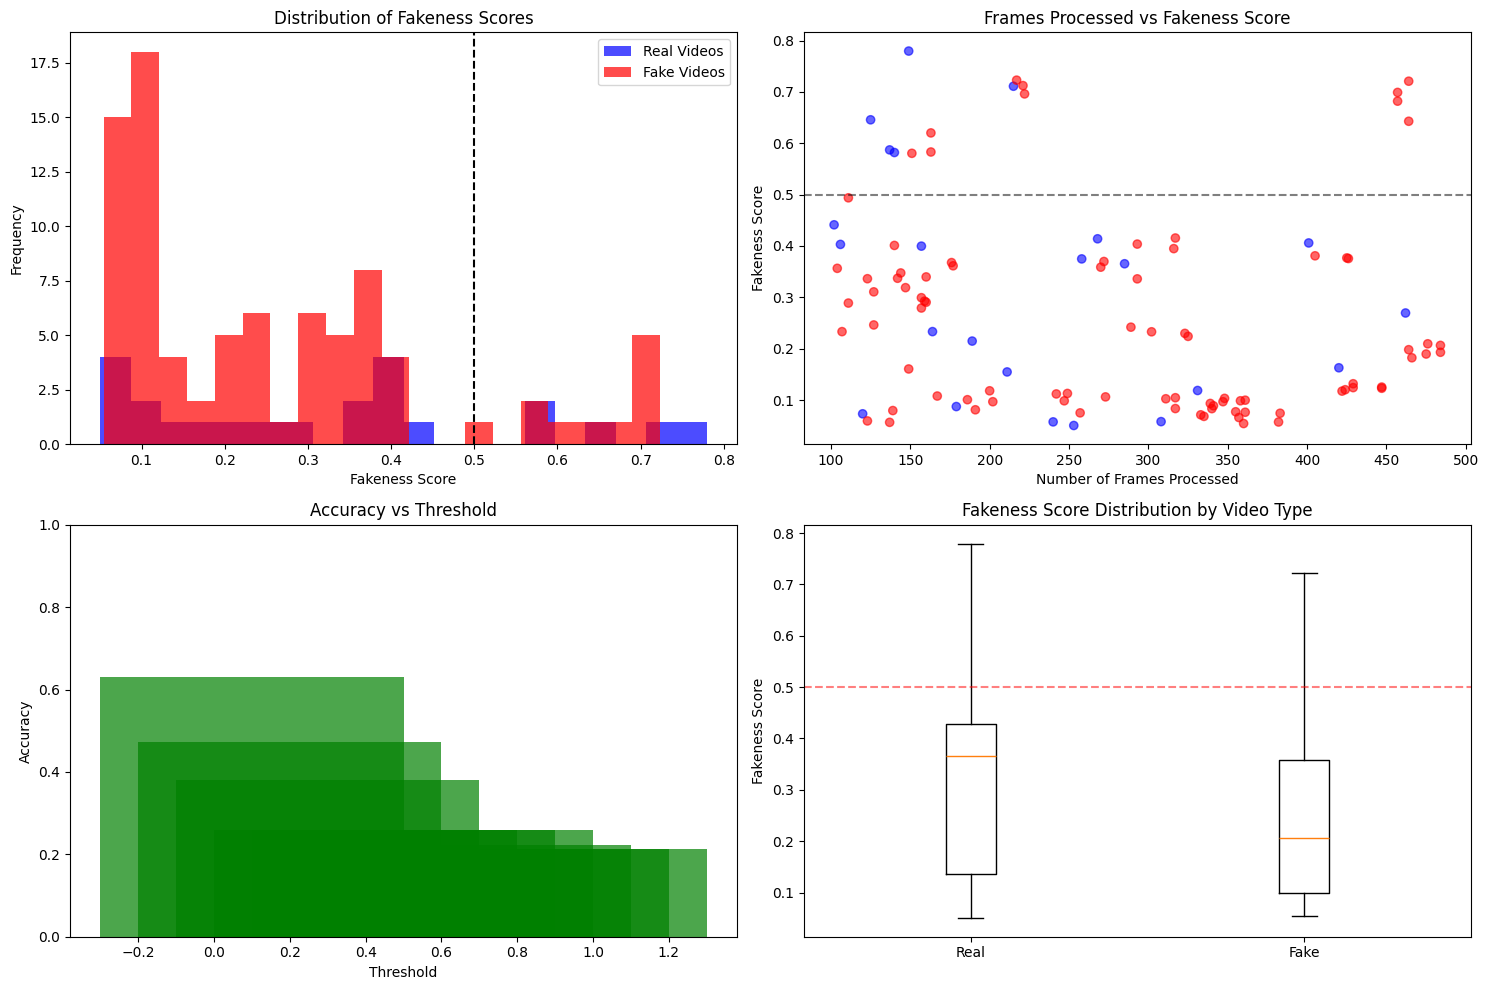

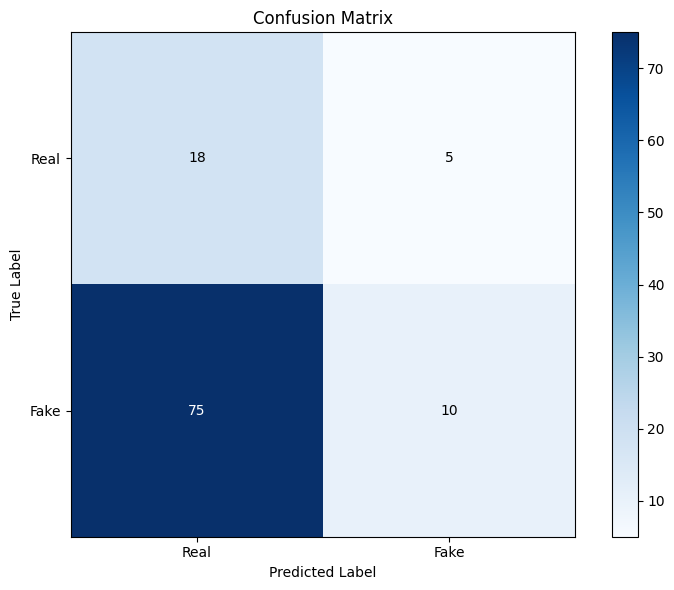


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        Real       0.19      0.78      0.31        23
        Fake       0.67      0.12      0.20        85

    accuracy                           0.26       108
   macro avg       0.43      0.45      0.26       108
weighted avg       0.57      0.26      0.22       108



In [24]:
# Trực quan hóa kết quả
if len(new_metadata) > 0:
    import matplotlib.pyplot as plt
    
    # Tạo figure với nhiều subplot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Histogram so sánh fakeness scores
    real_scores = [meta['final_fakeness_score'] for meta in new_metadata if meta['n_fakes'] == 0]
    fake_scores = [meta['final_fakeness_score'] for meta in new_metadata if meta['n_fakes'] > 0]
    
    axes[0, 0].hist(real_scores, bins=20, alpha=0.7, label='Real Videos', color='blue')
    axes[0, 0].hist(fake_scores, bins=20, alpha=0.7, label='Fake Videos', color='red')
    axes[0, 0].set_xlabel('Fakeness Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Fakeness Scores')
    axes[0, 0].legend()
    axes[0, 0].axvline(x=0.5, color='black', linestyle='--', label='Threshold')
    
    # 2. Scatter plot: Number of frames vs Fakeness score
    frames_processed = [meta['total_frames_processed'] for meta in new_metadata]
    all_scores = [meta['final_fakeness_score'] for meta in new_metadata]
    colors = ['red' if meta['n_fakes'] > 0 else 'blue' for meta in new_metadata]
    
    axes[0, 1].scatter(frames_processed, all_scores, c=colors, alpha=0.6)
    axes[0, 1].set_xlabel('Number of Frames Processed')
    axes[0, 1].set_ylabel('Fakeness Score')
    axes[0, 1].set_title('Frames Processed vs Fakeness Score')
    axes[0, 1].axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
    
    # 3. Bar chart: Accuracy by different thresholds
    thresholds = np.arange(0.1, 1.0, 0.1)
    accuracies = []
    
    for thresh in thresholds:
        correct = 0
        for meta in new_metadata:
            predicted_fake = meta['final_fakeness_score'] > thresh
            actual_fake = meta['n_fakes'] > 0
            if predicted_fake == actual_fake:
                correct += 1
        accuracies.append(correct / len(new_metadata))
    
    axes[1, 0].bar(thresholds, accuracies, alpha=0.7, color='green')
    axes[1, 0].set_xlabel('Threshold')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Accuracy vs Threshold')
    axes[1, 0].set_ylim(0, 1)
    
    # 4. Box plot: Fakeness scores by video type
    data_to_plot = [real_scores, fake_scores]
    axes[1, 1].boxplot(data_to_plot, labels=['Real', 'Fake'])
    axes[1, 1].set_ylabel('Fakeness Score')
    axes[1, 1].set_title('Fakeness Score Distribution by Video Type')
    axes[1, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Tạo confusion matrix
    
    # Chuẩn bị dữ liệu cho confusion matrix
    y_true = [1 if meta['n_fakes'] > 0 else 0 for meta in new_metadata]  # 1 = fake, 0 = real
    y_pred = [1 if meta['final_fakeness_score'] > 0.5 else 0 for meta in new_metadata]
    
    cm = confusion_matrix(y_true, y_pred)
    
    # Vẽ confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Real', 'Fake'])
    plt.yticks(tick_marks, ['Real', 'Fake'])
    
    # Thêm text vào confusion matrix
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # In classification report
    print("\n=== CLASSIFICATION REPORT ===")
    print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))
    
else:
    print("Không có dữ liệu để trực quan hóa!")

In [23]:
# Install scikit-learn nếu chưa có
try:
    from sklearn.metrics import confusion_matrix, classification_report
    print("scikit-learn đã có sẵn")
except ImportError:
    print("Đang cài đặt scikit-learn...")
    !pip install scikit-learn
    from sklearn.metrics import confusion_matrix, classification_report
    print("Đã cài đặt scikit-learn thành công")

scikit-learn đã có sẵn


In [2]:
# Liệt kê các file video thực tế có trong thư mục LAV_DF_Small và phân loại real/fake
import json
import os

def analyze_actual_videos():
    # Đường dẫn tới thư mục và metadata
    base_path = '/mnt/e/FPTUNI/doantotnghiep/Comparing Models/SelfBlendedImages/LAV_DF_Small/LAV_DF_Small'
    metadata_path = os.path.join(base_path, 'metadata.min.json')
    
    try:
        # Đọc metadata
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        # Tạo dictionary để tra cứu metadata theo tên file
        metadata_dict = {}
        for item in metadata:
            filename = os.path.basename(item['file'])
            metadata_dict[filename] = item
        
        # Lấy danh sách file thực tế có trong thư mục
        actual_files = [f for f in os.listdir(base_path) if f.endswith('.mp4')]
        actual_files.sort()
        
        print(f"=== PHÂN TÍCH FILE VIDEO THỰC TẾ TRONG THƯMỤC LAV_DF_Small ===")
        print(f"Tổng số file .mp4 có trong thư mục: {len(actual_files)}")
        print(f"Tổng số entries trong metadata: {len(metadata)}")
        
        # Phân loại file thực tế
        existing_real = []
        existing_fake = []
        no_metadata = []
        
        for filename in actual_files:
            if filename in metadata_dict:
                meta = metadata_dict[filename]
                if meta['n_fakes'] == 0:  # Video thật
                    existing_real.append({
                        'filename': filename,
                        'frames': meta.get('video_frames', 'N/A'),
                        'target': meta.get('target', 'N/A')
                    })
                else:  # Video fake
                    existing_fake.append({
                        'filename': filename,
                        'frames': meta.get('video_frames', 'N/A'),
                        'n_fakes': meta['n_fakes'],
                        'target': meta.get('target', 'N/A')
                    })
            else:
                no_metadata.append(filename)
        
        # Thống kê
        print(f"\n=== THỐNG KÊ PHÂN LOẠI ===")
        print(f"File REAL: {len(existing_real)}")
        print(f"File FAKE: {len(existing_fake)}")
        print(f"File không có metadata: {len(no_metadata)}")
        
        # Hiển thị danh sách file REAL
        print(f"\n=== DANH SÁCH FILE REAL ({len(existing_real)} files) ===")
        if len(existing_real) > 0:
            for i, video in enumerate(existing_real):
                print(f"{i+1:3d}. {video['filename']} (Frames: {video['frames']})")
        else:
            print("Không có file REAL nào")
        
        # Hiển thị danh sách file FAKE  
        print(f"\n=== DANH SÁCH FILE FAKE ({len(existing_fake)} files) ===")
        if len(existing_fake) > 0:
            for i, video in enumerate(existing_fake):
                print(f"{i+1:3d}. {video['filename']} (Frames: {video['frames']}, N_fakes: {video['n_fakes']})")
        else:
            print("Không có file FAKE nào")
        
        # Hiển thị file không có metadata (nếu có)
        if len(no_metadata) > 0:
            print(f"\n=== FILE KHÔNG CÓ METADATA ({len(no_metadata)} files) ===")
            for i, filename in enumerate(no_metadata):
                print(f"{i+1:3d}. {filename}")
        
        # Tạo danh sách đơn giản để dễ sử dụng
        real_files = [v['filename'] for v in existing_real]
        fake_files = [v['filename'] for v in existing_fake]
        
        print(f"\n=== TỔNG KẾT ===")
        print(f"Danh sách file REAL: {real_files[:5]}{'...' if len(real_files) > 5 else ''}")
        print(f"Danh sách file FAKE: {fake_files[:5]}{'...' if len(fake_files) > 5 else ''}")
        
        return {
            'real_files': real_files,
            'fake_files': fake_files, 
            'no_metadata': no_metadata,
            'real_details': existing_real,
            'fake_details': existing_fake,
            'total_files': len(actual_files)
        }
        
    except FileNotFoundError:
        print(f"Không tìm thấy file metadata tại: {metadata_path}")
        return None
    except json.JSONDecodeError:
        print(f"Lỗi decode JSON từ file: {metadata_path}")
        return None
    except Exception as e:
        print(f"Lỗi: {str(e)}")
        return None

# Chạy phân tích
result = analyze_actual_videos()

=== PHÂN TÍCH FILE VIDEO THỰC TẾ TRONG THƯMỤC LAV_DF_Small ===
Tổng số file .mp4 có trong thư mục: 108
Tổng số entries trong metadata: 136304

=== THỐNG KÊ PHÂN LOẠI ===
File REAL: 23
File FAKE: 85
File không có metadata: 0

=== DANH SÁCH FILE REAL (23 files) ===
  1. 000012.mp4 (Frames: 189)
  2. 000016.mp4 (Frames: 164)
  3. 000404.mp4 (Frames: 149)
  4. 000408.mp4 (Frames: 215)
  5. 000469.mp4 (Frames: 125)
  6. 000473.mp4 (Frames: 102)
  7. 000477.mp4 (Frames: 140)
  8. 000481.mp4 (Frames: 137)
  9. 000485.mp4 (Frames: 106)
 10. 000489.mp4 (Frames: 401)
 11. 113696.mp4 (Frames: 308)
 12. 113700.mp4 (Frames: 240)
 13. 113704.mp4 (Frames: 253)
 14. 114583.mp4 (Frames: 462)
 15. 114590.mp4 (Frames: 285)
 16. 114661.mp4 (Frames: 268)
 17. 114668.mp4 (Frames: 157)
 18. 114672.mp4 (Frames: 258)
 19. 117877.mp4 (Frames: 420)
 20. 117884.mp4 (Frames: 211)
 21. 117889.mp4 (Frames: 331)
 22. 117896.mp4 (Frames: 179)
 23. 117897.mp4 (Frames: 120)

=== DANH SÁCH FILE FAKE (85 files) ===
  1. 0